![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

# Instructions
- Some part of the code is already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

In [1]:
# All imports
import numpy as np
import cv2
import pandas as pd
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
import random
import requests
from os import walk
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [3]:
#### Add your code here ####
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/assignments/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [123]:
# import numpy as np
data = np.load(project_path+"images.npy", allow_pickle=True)

In [124]:
data.shape

(409, 2)

There are 409 images

### Check one sample from the loaded "images.npy" file  (2 marks)
- Hint: print data[10][1] 

In [125]:
# Pick a randon number between 0-408
imageIndex = random.randint(0, 408)

In [126]:
#### Add your code here ####
data[imageIndex]

array([array([[[140, 123, 129],
        [141, 124, 130],
        [141, 124, 130],
        ...,
        [152, 141, 137],
        [153, 142, 138],
        [153, 142, 138]],

       [[143, 126, 132],
        [143, 126, 132],
        [141, 124, 130],
        ...,
        [158, 147, 143],
        [158, 147, 143],
        [156, 145, 141]],

       [[144, 127, 133],
        [143, 126, 132],
        [141, 124, 130],
        ...,
        [163, 152, 148],
        [161, 150, 146],
        [157, 146, 142]],

       ...,

       [[ 72,  55,  61],
        [185, 168, 174],
        [227, 210, 216],
        ...,
        [104,  88,  88],
        [106,  90,  90],
        [105,  89,  89]],

       [[ 82,  65,  71],
        [224, 207, 213],
        [255, 241, 247],
        ...,
        [101,  85,  85],
        [102,  86,  86],
        [100,  84,  84]],

       [[ 97,  80,  86],
        [220, 203, 209],
        [245, 228, 234],
        ...,
        [100,  84,  84],
        [ 99,  83,  83],
        [ 96,  80

In [127]:
# Image array
data[imageIndex][0]

array([[[140, 123, 129],
        [141, 124, 130],
        [141, 124, 130],
        ...,
        [152, 141, 137],
        [153, 142, 138],
        [153, 142, 138]],

       [[143, 126, 132],
        [143, 126, 132],
        [141, 124, 130],
        ...,
        [158, 147, 143],
        [158, 147, 143],
        [156, 145, 141]],

       [[144, 127, 133],
        [143, 126, 132],
        [141, 124, 130],
        ...,
        [163, 152, 148],
        [161, 150, 146],
        [157, 146, 142]],

       ...,

       [[ 72,  55,  61],
        [185, 168, 174],
        [227, 210, 216],
        ...,
        [104,  88,  88],
        [106,  90,  90],
        [105,  89,  89]],

       [[ 82,  65,  71],
        [224, 207, 213],
        [255, 241, 247],
        ...,
        [101,  85,  85],
        [102,  86,  86],
        [100,  84,  84]],

       [[ 97,  80,  86],
        [220, 203, 209],
        [245, 228, 234],
        ...,
        [100,  84,  84],
        [ 99,  83,  83],
        [ 96,  80,  80]]

In [128]:
# Box point array
data[imageIndex][1]

[{'imageHeight': 260,
  'imageWidth': 400,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3425, 'y': 0.1}, {'x': 0.51, 'y': 0.36923076923076925}]},
 {'imageHeight': 260,
  'imageWidth': 400,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.1175, 'y': 0.12307692307692308},
   {'x': 0.26, 'y': 0.36538461538461536}]},
 {'imageHeight': 260,
  'imageWidth': 400,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7225, 'y': 0.14615384615384616},
   {'x': 0.865, 'y': 0.4230769230769231}]}]

Lets try to plot the image and the face bounding box for the image

In [129]:
# Construct the image
img = Image.fromarray(data[imageIndex][0], 'RGB')

In [130]:
points = []
for i in range(0, len(data[imageIndex][1])):
  x0 = data[imageIndex][1][i]['points'][0]['x']*data[imageIndex][1][i]['imageWidth']
  x1 = data[imageIndex][1][i]['points'][1]['x']*data[imageIndex][1][i]['imageWidth']
  y0 = data[imageIndex][1][i]['points'][0]['y']*data[imageIndex][1][i]['imageHeight']
  y1 = data[imageIndex][1][i]['points'][1]['y']*data[imageIndex][1][i]['imageHeight']
  points.append({"x0":x0, "x1": x1, "y0": y0, "y1": y1})

In [131]:
points

[{'x0': 137.0, 'x1': 204.0, 'y0': 26.0, 'y1': 96.0},
 {'x0': 47.0, 'x1': 104.0, 'y0': 32.0, 'y1': 95.0},
 {'x0': 289.0, 'x1': 346.0, 'y0': 38.0, 'y1': 110.0}]

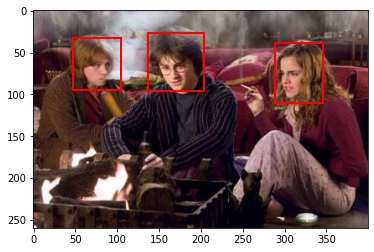

In [132]:
h = data[imageIndex][1][0]['imageHeight']
w = data[imageIndex][1][0]['imageWidth']

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

for point in points:
  # Create a Rectangle patch
  rect = patches.Rectangle((point['x0'], point['y0']), (point['x1'] - point['x0']) , (point['y1'] - point['y0']) , linewidth=2, edgecolor='r', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)
plt.show()

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [133]:
#### Add your code here ####
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [134]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [135]:
masks.shape

(409, 224, 224)

In [136]:
X.shape

(409, 224, 224, 3)

### Split the data into training and testing (2 marks)
- 400 images in training
- 9 images in testing data

Training data

In [137]:
X_train = X[:400]
y_train = masks[:400]

Testing data

In [138]:
X_test = X[400:]
y_test = masks[400:]

### Print a sample training image, image array and its mask (2 marks)

Print the image and image array

In [139]:
# Pick a randon number between 0-400
randomTrain = random.randint(0, 400)

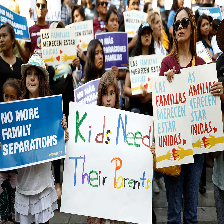

In [140]:
#### Add your code here ####
# Construct the image
img = tf.keras.preprocessing.image.array_to_img(X_train[randomTrain])
img

In [141]:
#### Add your code here ####
print(X_train[randomTrain])

[[[ 1.          1.          1.        ]
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]
  ...
  [ 0.93725491  0.93725491  0.93725491]
  [ 0.97647059  0.97647059  0.97647059]
  [ 0.99215686  0.99215686  0.99215686]]

 [[ 1.          1.          1.        ]
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]
  ...
  [ 0.96862745  0.96862745  0.96862745]
  [ 1.          1.          1.        ]
  [ 0.99215686  0.99215686  0.99215686]]

 [[ 0.99215686  0.99215686  0.99215686]
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]
  ...
  [ 1.          1.          1.        ]
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]]

 ...

 [[-0.7019608  -0.68627453 -0.69411767]
  [-0.06666666 -0.09019607 -0.12941176]
  [-0.38039213 -0.45098037 -0.49803919]
  ...
  [-0.72549021 -0.7019608  -0.64705884]
  [-0.63137257 -0.60784316 -0.5529412 ]
  [-0.78039217 -0.75686276 -0.7019608 ]]

 [

Print the mask

In [142]:
#### Add your code here ####
print(y_train[randomTrain])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Create the model (5 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [143]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

# HEIGHT_CELLS= 28
# WIDTH_CELLS = 28

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    #### Add your code here ####
    # block1 = model.get_layer("input_1").output
    block2 = model.get_layer("conv_dw_1_relu").output
    block3 = model.get_layer("conv_dw_3_relu").output
    block4 = model.get_layer("conv_pw_5_relu").output
    block5 = model.get_layer("conv_pw_11_relu").output
    block6 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block6), block5])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    # x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(4, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function (1 mark)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [144]:
#### Add your code here ####
model = create_model(False)

### Print model summary (1 mark)

In [145]:
#### Add your code here ####
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
____________________________________________________________________________________________

### Define dice coefficient function (2 marks)
- Create a function to calculate dice coefficient


In [146]:
#### Add your code here ####
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss function (2 marks)

In [147]:
#### Add your code here ####
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [148]:
#### Add your code here ####
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=dice_coefficient)

### Define callbacks (2 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [149]:
#### Add your code here ####
checkpoint = ModelCheckpoint("model-{loss}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1)
stop = EarlyStopping(monitor="loss", patience=10, mode="auto")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [150]:
#### Add your code here ####
model.fit(epochs=200,
          batch_size=1,
          callbacks=[checkpoint, stop, reduce_lr],
          x=X_train,
          y= y_train)

Epoch 1/200
400/400 [==============================] - 4s 7ms/step - loss: 2.5490 - dice_coefficient: 0.1749

Epoch 00001: loss improved from inf to 2.37077, saving model to model-2.370771884918213.h5
Epoch 2/200
400/400 [==============================] - 3s 7ms/step - loss: 2.0996 - dice_coefficient: 0.2382

Epoch 00002: loss improved from 2.37077 to 2.06416, saving model to model-2.0641584396362305.h5
Epoch 3/200
400/400 [==============================] - 3s 7ms/step - loss: 1.9638 - dice_coefficient: 0.2622

Epoch 00003: loss improved from 2.06416 to 1.96145, saving model to model-1.9614498615264893.h5
Epoch 4/200
400/400 [==============================] - 3s 7ms/step - loss: 1.9034 - dice_coefficient: 0.2771

Epoch 00004: loss improved from 1.96145 to 1.89609, saving model to model-1.8960859775543213.h5
Epoch 5/200
400/400 [==============================] - 3s 7ms/step - loss: 1.8803 - dice_coefficient: 0.2844

Epoch 00005: loss improved from 1.89609 to 1.84192, saving model to mod

### Get the predicted mask for a test image   (2 marks)

In [151]:
# Pick a randon number between 0-9 for test image
randomTest = random.randint(0, 8)

Show the test image

In [152]:
image = X_test[randomTest]

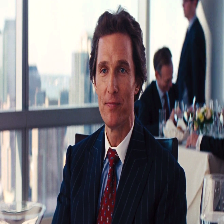

In [153]:
#### Add your code here ####
tf.keras.preprocessing.image.array_to_img(image)

Show original mask for test image

In [154]:
maskedImg = cv2.resize(y_test[randomTest], (IMAGE_WIDTH, IMAGE_HEIGHT))

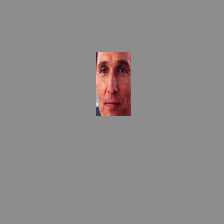

In [155]:
#### Add your code here ####
pred_mask = cv2.resize(maskedImg, (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

tf.keras.preprocessing.image.array_to_img(out_image)

Predict the mask on the test image

In [156]:
#### Add your code here ####
image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
# feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([image]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

In [157]:
pred_mask.shape

(224, 224)

In [158]:
image.shape

(224, 224, 3)

### Impose the mask on the test image (2 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

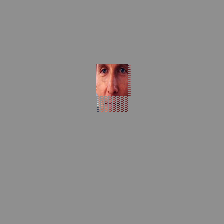

In [159]:
#### Add your code here ####
image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

tf.keras.preprocessing.image.array_to_img(out_image)